In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import jax.numpy as np
from jax import lax, nn, random, vmap
from jax._src.nn.functions import normalize
from jax.experimental import stax
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal
from jax.random import normal as norm
from jax import lax

In [3]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
from patch_gnn.unirep import unirep_reps
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import seaborn as sns

##### Load dataset, split into train and test, then one hot encode it

In [4]:
# load graphs
graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# load data
data = load_ghesquire()

# filter data based on graphs.keys() and other metrics
filtered = (
   data
   .query("`accession-sequence` in @graphs.keys()")
   .query("ox_fwd_logit < 2.0")
   .join_apply(met_position, "met_position")
)

# split data into train and testing
key = random.PRNGKey(490)
train_df, test_df = train_test_split(key, filtered) # 70% training, 30% testing
print(f"the shape of train_df and test_df are {train_df.shape}, {test_df.shape}")

# pad sequence to 50 length and one hot encode it
padding_length = 50
train_oh = one_hot(train_df, padding_length) 
test_oh = one_hot(test_df,padding_length)
print(f"the shape of train_oh and test_oh are {train_oh.shape}, {test_oh.shape}")

the shape of train_df and test_df are (258, 18), (111, 18)
the shape of train_oh and test_oh are (258, 1050), (111, 1050)


##### reshape data to fit LSTM and get target values

In [6]:
lstm_train_oh = train_oh.reshape(train_oh.shape[0], padding_length, 21)
lstm_test_oh = test_oh.reshape(test_oh.shape[0], padding_length, 21)
print(lstm_train_oh.shape, lstm_test_oh.shape)
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

(258, 50, 21) (111, 50, 21)


In [8]:
batch_size = 1
lstm_train_oh[0:batch_size,:,:].shape, train_target[0:batch_size,].shape

((1, 50, 21), (1,))

#### LSTM based on JAX unirep's case study

In [9]:
def AAEmbedding(embedding_dims: int , E_init=glorot_normal(), **kwargs):
    """
    Initial n-dimensional embedding of each amino-acid, like a dense layer without bias
    """

    def init_fun(rng, input_shape):
        """
        Generates the inital AA embedding matrix.
        `input_shape`:
            one-hot encoded AA sequence -> (n_aa, n_unique_aa)
        `output_dims`:
            embedded sequence -> (n_aa, embedding_dims)
        `emb_matrix`:
            embedding matrix -> (n_unique_aa, embedding_dims)
        """
        emb_matrix = E_init(rng, (input_shape[-1], embedding_dims))
        output_dims = (-1, embedding_dims)#-1 means it can be of any number 
    
        return output_dims, emb_matrix

    def apply_fun(params, inputs, **kwargs):
        """
        Embed a single AA sequence
        """
        emb_matrix = params
        # (n_aa, n_unique_aa) * (n_unique_aa, embedding_dims) => (n_aa, embedding_dims) # noqa: E501
        return np.matmul(inputs, emb_matrix)

    return init_fun, apply_fun

In [17]:
def LSTM(out_dim, W_init=glorot_normal(), b_init=normal()):
    """
    one directional LSTM, see math here https://d2l.ai/chapter_recurrent-modern/lstm.html
    :params out_dim: number of output neurons associated with an input of a single time point
    
    """
    def init_fun(rng, input_shape):
        """
        initialize LSTM layer for stax
        :param rng: The PRNGKey (from JAX) for random number generation _reproducibility_.
        :params input_shape: (num_time_steps/n_letters, embeddings)
        """
        # initial hidden state and memory state ---- don't set it this way since params are not supposed to be tuple of tuples
        #hidden = b_init(rng, (1, out_dim)) # denote by H in the formula #b_init(rng, (input_shape[0], out_dim)), instead None can be any number
        #memory = b_init(rng, (1, out_dim)) # denote by C in the formula #b_init(rng, (input_shape[0], out_dim))
        # input gate
        k1, k2, k3 = random.split(rng, num=3)
        input_W, input_U, input_b = (
            W_init(k1, (input_shape[-1], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        # forget gate
        k1, k2, k3 = random.split(rng, num=3)
        forget_W, forget_U, forget_b = (
            W_init(k1, (input_shape[-1], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        # output gate
        k1, k2, k3 = random.split(rng, num=3)
        output_W, output_U, output_b = (
            W_init(k1, (input_shape[-1], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        # current memory 
        k1, k2, k3 = random.split(rng, num=3)
        candidate_m_W, candidate_m_U, candidate_m_b = (
            W_init(k1, (input_shape[-1], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),
        )
        
        
        output_shape = (1,out_dim) #(out_dim, )#,input_shape[0] or 1? I think it should be 1 since each sample is input into the algorithm each time. input_shape[0] should be dim of the previous layer
        return (output_shape, (input_W, input_U, input_b, forget_W, forget_U, forget_b, output_W, output_U, output_b, candidate_m_W, candidate_m_U, candidate_m_b))# this tuple is (output_shape, params)
        #return (output_shape,
        #       ((hidden, memory),
        #       (input_W, input_U, input_b),
        #       (forget_W, forget_U, forget_b),
        #       (output_W, output_U, output_b),
        #       (candidate_m_W, candidate_m_U, candidate_m_b)),) # this tuple is (output_shape, params)
    
    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        #h_0, m_0 = params[0] # initial hidden and memory, not do it this way since params contain values one is going to optimize
        h_0 = np.zeros((1, out_dim))
        m_0 = np.zeros((1, out_dim))
        #print(f"inputs shape {inputs.shape}")  # input should be (num_timestep, embedding), num_timestep=50

        def apply_fun_scan(params, carry, inputs):
            """ 
            Perform single step update of the network
            carry: a tuple with (hidden, memory)
            :param input: of shape 
            """
            (hidden, memory) = carry  # carry has to be a tuple, b/c this function will be used by lax.scan and it has to be 2 inputs not 3
            input_W, input_U, input_b, forget_W, forget_U, forget_b, output_W, output_U, output_b, candidate_m_W, candidate_m_U, candidate_m_b = params
#             (i,j), (input_W, input_U, input_b), (forget_W, forget_U, forget_b), (
#                 output_W, output_U, output_b),(
#                 candidate_m_W, candidate_m_U, candidate_m_b) = params
            #print(f"input_W shape: {input_W.shape}, input_U shape: {input_U.shape}, input_b shape: {input_b.shape}" )
            # shape annotation: (1,embedding)*(embedding, outdim) +(1, outdim)*(outdim, outdim) => (1, outdim)
            input_gate = sigmoid(np.dot(inputs, input_W) +
                                  np.dot(hidden, input_U) + input_b)
            # shape annotation: (1,embedding)*(embedding, outdim) +(1, outdim)*(outdim, outdim)=> (1, outdim)
            forget_gate = sigmoid(np.dot(inputs, forget_W) +
                                 np.dot(hidden, forget_U) + forget_b)
            # shape annotation: (1,embedding)*(embedding, outdim) +(1, outdim)*(outdim, outdim)=> (1, outdim)
            output_gate = sigmoid(np.dot(inputs, output_W) +
                                 np.dot(hidden, output_U) + output_b)
            # shape annotation: (1,embedding)*(embedding, outdim) +(1, outdim)*(outdim, outdim)=> (1, outdim)
            candidate_memory = np.tanh(np.dot(inputs, candidate_m_W) +
                                 np.dot(hidden, candidate_m_U) + candidate_m_b)
            # shape annotation: (1,outdim)@(1,outdim) + 1,outdim)@(1,outdim)=> (1, outdim)
            #print(f"forget_gate shape: {forget_gate.shape}, memory shape: {memory.shape}, input_gate shape:{input_gate.shape}, cadidate_memory shape: {candidate_memory.shape}")
            current_memory = np.multiply(forget_gate, memory) + np.multiply(input_gate, candidate_memory)
            # shape annotation: (1,outdim)@(1, outdim)=> (1, outdim)
            current_hidden = np.multiply(output_gate, np.tanh(current_memory))
            #print(f"current_memory shape: {current_memory.shape}, hidden shape: {hidden.shape}")
            hidden = current_hidden
            memory = current_memory

            return (hidden, memory), hidden  # it has to be in this format because lax.scan output requires it to be of the shape of the function output

        f = partial(apply_fun_scan, params) # this is a function
        (h_final, m_final), output = lax.scan(f, init=(h_0, m_0), xs=inputs)
        
        #print(f"h_final shape is {h_final.shape}, m_final shape is {m_final.shape}, output shape is {output.shape}")
        return (h_final, m_final), output #h_final shape is (1, outdim), m_final shape is (1, outdim), output shape is (n_timestep, 1, outdim)

    return init_fun, apply_fun





In [18]:
# need to make another layer between lstm to dense to get rid of the tuple returned by lstm
def LSTMHiddenStates(**kwargs):
    """
    Returns the full hidden states (last element) of the mLSTM layer.
    """

    def init_fun(rng, input_shape):
        output_shape = (input_shape[1],) # input_shape is the output shape of the LSTM, which is specified in the init_func
        return output_shape, ()

    def apply_fun(params, inputs, **kwargs):
        return inputs[0][0] # this is h_final, look at the actual output by lstm (h_final, m_final), output

    return init_fun, apply_fun

#### next step we want to generate some inputs for LSTM layer for testing

In [19]:
from jax import value_and_grad, jit,grad
from jax.experimental import stax
from patch_gnn.training import mseloss
from jax.experimental.optimizers import adam
from tqdm.auto import tqdm

# Initialize the network and perform a forward pass
vanilla_lstm_init_fun, vanilla_lstm_apply_fun = stax.serial(
    AAEmbedding(17), 
    stax.Sigmoid, 
    LSTM(32),
    LSTMHiddenStates(),
    #stax.Relu, don't use relu given the output are mostly negatives
    stax.Dense(1))#Dense(lstm_train_oh.shape[0])

#vanilla_lstm_init_fun, vanilla_lstm_apply_fun = LSTM(32)
_, params = vanilla_lstm_init_fun(key, (lstm_train_oh.shape[0], padding_length, 21)) # params here include params of all layers


def mse_loss(params,predict, inputs, targets):
#    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = predict(params, inputs)
#    preds = vmap(partial(predict, params))(inputs)
    return np.mean((preds - targets)**2)
# the following update function is the same as step function in patch_gnn.training
def fit(
    lstm_train_oh ,
    train_target ,
    num_epochs: int,
    params, #default for params is the pre-trained weights
    #batch_size: int = 25,
    #holdout_seqs: Optional[Iterable[str]] = None,
    #proj_name: str = "temp",
    #epochs_per_print: int = 1,
    step_size: float = 0.0001,
    model_func = vanilla_lstm_apply_fun,
    backend: str = "cpu",
    
):
    """referencing unirep https://github.com/ElArkk/jax-unirep/blob/12209f58165daac30fe0d8e8ccece9d9cdec02e7/jax_unirep/evotuning.py fit function"""
    @jit
    def step(i, x, y, state):
        """ Perform one timestep forward pass of all layers, calculate the MSE & perform a SGD step. """
        params = get_params(state)
        g = grad(partial(mse_loss, predict = model_func))(params, inputs= x, targets = y)
        state = update(i, g, state) # update the state based on gradient using adam
        return state  # states have params in a form adam can use
 
    ########### tell adam about the parameters to optimize, this initlize params for step function
    init, update, get_params = adam(step_size=step_size)
    get_params = jit(get_params)
    state = init(params)
    
    for epoch in tqdm(range(num_epochs)):
        loss_within_epoch = []
        for batch_idx in tqdm(range(lstm_train_oh.shape[0])):
            x_in = lstm_train_oh[batch_idx, :, :]
            y = train_target[batch_idx:batch_idx+1, ]
            for timestep in range(padding_length):
            #print(f"x_in shape is {x_in.shape},y shape is {y.shape}")
                state = step(timestep, x_in, y, state)
                loss = mse_loss(get_params(state),model_func, x_in, y)
                
                # get the loss of last time point
                if timestep == (padding_length-1):
                    # calculate within epoch loss avg
                    loss_within_epoch.append(loss)
                    
                    print(f"loss for time step {timestep} is {loss}")
        avg_loss_in_epoch = np.mean(np.array(loss_within_epoch))
        print(f"average loss for this epoch is {avg_loss_in_epoch}")
    return get_params(state)  # in the end, get the params from the final state
    
    


In [73]:
def predict(tuned_params, test_set_x, test_target, model_apply_fun ):
    """
    predict the output for test set and calculate the loss, returns pred_test: a list, and mse_loss: a float, and explained_var_score: int
    :param tuned_params: the tuned params from training by calling the `fit` function
    :param test_set_x: same shape as train set of shape (n_samples, padding_length, n_unique_letters)
    :param test_target: same shape as train_target, of shape (n_samples, )
    :param model_apply_fun: the apply_fun of the jax.serial model, e.g vanilla_lstm_apply_fun
    """
    pred_test = []
    for batch_idx in tqdm(range(test_set_x.shape[0])):
        pred_test_idx = model_apply_fun(tuned_params, test_set_x[batch_idx,:,: ]) 
        pred_test.append(pred_test_idx)
    # reshape pred_test to ndarray
    pred_test = np.array(pred_test).reshape(len(pred_test),)
    mse_loss = np.mean((pred_test - test_target)**2)
    # explained_var_score from https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score
    explained_var_score = 1- (np.var(test_target - pred_test)/(np.var(test_target)))
    return pred_test, mse_loss, explained_var_score

##### If the inputs in LSTM `apply_fun` is reshaped, the dimension problem will be solved but there will be another error
###### input: (50,21) --> AAembedding --> (50, 17) --> (1,17) x 50 time steps --> LSTM --> (1,32) after 50 timesteps
### The model takes a lot of time to train, each epoch takes 31 min on avg

In [20]:
tuned_params = fit(lstm_train_oh, train_target, num_epochs=5,  params=params, model_func=vanilla_lstm_apply_fun)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

loss for time step 49 is 17.385520935058594
loss for time step 49 is 0.6765739917755127
loss for time step 49 is 10.402125358581543
loss for time step 49 is 2.1415634155273438
loss for time step 49 is 0.4177894592285156
loss for time step 49 is 1.8039796352386475
loss for time step 49 is 1.7699885368347168
loss for time step 49 is 4.36460542678833
loss for time step 49 is 0.2719963788986206
loss for time step 49 is 0.0637504979968071
loss for time step 49 is 0.23256538808345795
loss for time step 49 is 8.307567596435547
loss for time step 49 is 0.019412856549024582
loss for time step 49 is 4.224788188934326
loss for time step 49 is 0.032604366540908813
loss for time step 49 is 6.035412788391113
loss for time step 49 is 0.025207258760929108
loss for time step 49 is 6.363267311826348e-05
loss for time step 49 is 1.0819110870361328
loss for time step 49 is 0.049980927258729935
loss for time step 49 is 2.3452324867248535
loss for time step 49 is 6.022099494934082
loss for time step 49 is 1

  0%|          | 0/258 [00:00<?, ?it/s]

loss for time step 49 is 4.70387077331543
loss for time step 49 is 1.0506112575531006
loss for time step 49 is 2.2751007080078125
loss for time step 49 is 0.014551027677953243
loss for time step 49 is 0.6430402398109436
loss for time step 49 is 0.0013195560313761234
loss for time step 49 is 0.027071937918663025
loss for time step 49 is 1.113188624382019
loss for time step 49 is 2.163701295852661
loss for time step 49 is 1.2698752880096436
loss for time step 49 is 0.09711727499961853
loss for time step 49 is 4.6928629875183105
loss for time step 49 is 0.2664697766304016
loss for time step 49 is 2.149998664855957
loss for time step 49 is 0.520014226436615
loss for time step 49 is 3.9170093536376953
loss for time step 49 is 0.07526277750730515
loss for time step 49 is 0.15227995812892914
loss for time step 49 is 2.0168299674987793
loss for time step 49 is 0.015986783429980278
loss for time step 49 is 3.461209535598755
loss for time step 49 is 4.623901844024658
loss for time step 49 is 1.0

  0%|          | 0/258 [00:00<?, ?it/s]

loss for time step 49 is 4.679271697998047
loss for time step 49 is 1.059089183807373
loss for time step 49 is 2.255720615386963
loss for time step 49 is 0.016113948076963425
loss for time step 49 is 0.6497968435287476
loss for time step 49 is 0.0010733363451436162
loss for time step 49 is 0.02589091844856739
loss for time step 49 is 1.101568341255188
loss for time step 49 is 2.1713778972625732
loss for time step 49 is 1.266916275024414
loss for time step 49 is 0.09521597623825073
loss for time step 49 is 4.67894983291626
loss for time step 49 is 0.2695111632347107
loss for time step 49 is 2.1344470977783203
loss for time step 49 is 0.5260823369026184
loss for time step 49 is 3.890307903289795
loss for time step 49 is 0.07885445654392242
loss for time step 49 is 0.15650413930416107
loss for time step 49 is 2.023925542831421
loss for time step 49 is 0.016356611624360085
loss for time step 49 is 3.448570728302002
loss for time step 49 is 4.617785930633545
loss for time step 49 is 1.01380

  0%|          | 0/258 [00:00<?, ?it/s]

loss for time step 49 is 4.666069030761719
loss for time step 49 is 1.0643385648727417
loss for time step 49 is 2.246622323989868
loss for time step 49 is 0.016856851056218147
loss for time step 49 is 0.6533167362213135
loss for time step 49 is 0.000951100664678961
loss for time step 49 is 0.025301676243543625
loss for time step 49 is 1.0966696739196777
loss for time step 49 is 2.1753342151641846
loss for time step 49 is 1.267270565032959
loss for time step 49 is 0.09483027458190918
loss for time step 49 is 4.672245979309082
loss for time step 49 is 0.27100545167922974
loss for time step 49 is 2.128563642501831
loss for time step 49 is 0.5283529162406921
loss for time step 49 is 3.8787829875946045
loss for time step 49 is 0.08043672144412994
loss for time step 49 is 0.1580946147441864
loss for time step 49 is 2.0257277488708496
loss for time step 49 is 0.016446320340037346
loss for time step 49 is 3.445176601409912
loss for time step 49 is 4.615749835968018
loss for time step 49 is 1.0

  0%|          | 0/258 [00:00<?, ?it/s]

loss for time step 49 is 4.652132987976074
loss for time step 49 is 1.0712687969207764
loss for time step 49 is 2.239184856414795
loss for time step 49 is 0.017418138682842255
loss for time step 49 is 0.6576134562492371
loss for time step 49 is 0.0008014730410650373
loss for time step 49 is 0.024602999910712242
loss for time step 49 is 1.094420313835144
loss for time step 49 is 2.1814537048339844
loss for time step 49 is 1.270912528038025
loss for time step 49 is 0.09513683617115021
loss for time step 49 is 4.661959171295166
loss for time step 49 is 0.27349719405174255
loss for time step 49 is 2.1255462169647217
loss for time step 49 is 0.530413031578064
loss for time step 49 is 3.880742311477661
loss for time step 49 is 0.08008157461881638
loss for time step 49 is 0.15792876482009888
loss for time step 49 is 2.0298731327056885
loss for time step 49 is 0.016899099573493004
loss for time step 49 is 3.4508681297302246
loss for time step 49 is 4.6059041023254395
loss for time step 49 is 1

#### Save tuned params

In [23]:
import pickle
with open('aa_embed_17_sigmoid_lstm_32_lstm_hiddenstate_dense_5_epochs_weights.pkl', 'wb') as f:
    pickle.dump(tuned_params, f)

In [24]:
with open('aa_embed_17_sigmoid_lstm_32_lstm_hiddenstate_dense_5_epochs_weights.pkl', 'rb') as f:
    new_weights = pickle.load(f)

#### Evaluate on test set

In [78]:
pred_train, train_mse_loss, train_explained_var_score =  predict(tuned_params=tuned_params, 
                                                    test_set_x=lstm_train_oh, test_target = train_target, model_apply_fun=vanilla_lstm_apply_fun )

  0%|          | 0/258 [00:00<?, ?it/s]

In [80]:
pred_test, test_mse_loss, test_explained_var_score =  predict(tuned_params=tuned_params, 
                                                    test_set_x=lstm_test_oh, test_target = test_target, model_apply_fun=vanilla_lstm_apply_fun )


  0%|          | 0/111 [00:00<?, ?it/s]

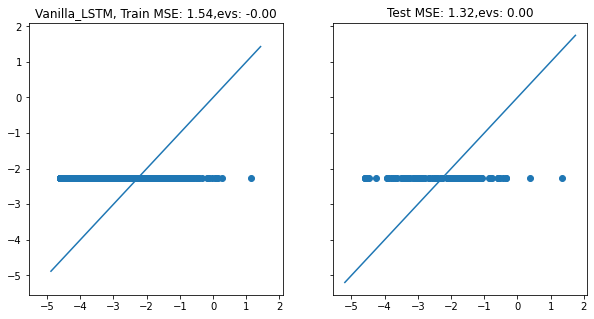

In [85]:
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)

    ax.plot([minval, maxval], [minval, maxval])


fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )


ax[0].scatter(train_target, pred_train)
ax[0].set_title(f"Vanilla_LSTM, Train MSE: {train_mse_loss:.2f},evs: {train_explained_var_score:.2f}")
plot_y_eq_x(ax[0])


ax[1].scatter(test_target, pred_test)
ax[1].set_title(f"Vanilla_LSTM, Test MSE: {test_mse_loss:.2f},evs: {test_explained_var_score:.2f}")
plot_y_eq_x(ax[1])

### Conclusion

It seems that many people are observing the model predicts the same outputs when using RNN models https://github.com/keras-team/keras/issues/6447, there are several solutions suggested by this github issues and I'm summarizing here:
 


- try reducing batch_size -> the batch size in the LSTM is 1, nothing to reduce any further
- figure out if there are NaN values in the dataset --> I looked and didn't find any
- Use the right activation function -> Only sigmoid activation was using after the AA_embedding layer, no other non-linear activation function were used after that. But I can try to remove that to see the output
- Use fewer layers --> currently, it is already the simplest model
- data augmentation, increase the size of the data -> not applicable
- scaling inputs --> currently using sigmoid to scale the embedding to (0,1), didn't help
- reduce the number of neurons per layer -> currently the embedding layer neuron is 17, and LSTM cells are 32. Might not worth shrinking further

#### Next step

Please look at notebooks/coxji1/LSTM-learn_from_jax_unirep_code-no_activation.ipynb, I removed the sigmiod activation function and it seems to perform slightly better (at least you'd see more variation of the output, rather than consistant output prediction)


# below code can be useful and was useful at some point

In [ ]:
from jax.experimental.optimizers import adam
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = adam(step_size)
opt_state = opt_init(params)

num_epochs = 10

In [ ]:
# Loop over the training epochs
loss = []
for epoch in range(num_epochs):
    for batch_idx in range(lstm_train_oh.shape[0]):
        x_in = lstm_train_oh[batch_idx, :, :]
        y = train_target[batch_idx:batch_idx+1, ]
        print(type(x_in), type(y))
        loss, grads = value_and_grad(mse_loss)(params, x_in, y)
        print(loss, grads)
        #params, opt_state, loss = update(params, x_in, y, opt_state)
        #train_loss_log.append(loss)





##### below part is what we want to do ultimately

In [ ]:
from jax.experimental import stax
from jax.experimental.optimizers import adam
class VanillaLSTM:
    """Vanilla shallow LSTM model in sklearn-compatible format.

    Forward direction LSTM + linear regression on top.
    """

    def __init__(
        self,
        one_hot_encoded_shape,
        #node_feature_shape,
        #num_adjacency,
        num_training_steps: int = 100,
        optimizer_step_size=1e-5,
    ):
        """
        :param one_hot_encoded_shape: (batch_size, timestep, embedding), timestep is the padding_length
        
        """
        model_init_fun, model_apply_fun = stax.serial(
            Dense(64), 
            stax.Sigmoid, 
            LSTM(32), 
            Dense(1)
        )
        self.model_apply_fun = model_apply_fun

        self.optimizer = adam(step_size=optimizer_step_size)

        output_shape, params = model_init_fun(
            PRNGKey(42), input_shape=(*one_hot_encoded_shape)
        )

        self.params = params
        self.num_training_steps = num_training_steps
        self.state_history = []
        self.loss_history = []

    def fit(self, X, y):
        """Fit model.

        :param X: tuple(timestep, embedding)
        :param y: vector(values to predict)
        """
        if len(y.shape) == 1:
            y = np.reshape(y, (-1, 1))
        init, update, get_params = self.optimizer
        training_step = partial(
            step,
            loss_fun=mseloss,
            apply_fun=self.model_apply_fun,
            update_fun=update,
            get_params=get_params,
            inputs=X,
            outputs=y,
        )
        training_step = jit(training_step)

        state = init(self.params)

        for i in tqdm(range(self.num_training_steps)):
            state, loss = training_step(i, state)
            self.state_history.append(state)
            self.loss_history.append(loss)

        self.params = get_params(state)
        return self

    def predict(self, X, checkpoint: int = None):
        """
        predict
        :param X: tuple(adjacency, node_features)
        """
        params = self.params
        if checkpoint:
            _, _, get_params = self.optimizer
            params = get_params(self.state_history[checkpoint])
        return vmap(partial(self.model_apply_fun, params))(X)

In [ ]:
num_training_steps = 50
model_vanilla_lstm = VanillaLSTM(
    one_hot_encoded_shape = (padding_length, 21)
    num_training_steps=num_training_steps
)
model_vanilla_lstm.fit(lstm_train_oh, train_target)

## Case study: GRU
### Implementation of GRU from https://towardsdatascience.com/getting-started-with-jax-mlps-cnns-rnns-d0bc389bd683
##### formula of GRU can be found at https://www.google.com/search?q=GRU+formula&tbm=isch&source=iu&ictx=1&fir=VgQCUBNNXFcaTM%252CXHoefSnHEDF68M%252C_&vet=1&usg=AI4_-kSHwsjZClZeI1h2s23kwDj5ncW6Jg&sa=X&ved=2ahUKEwjcwZaW8vjvAhUHKFkFHc8NC8sQ9QF6BAgNEAE&biw=1680&bih=895#imgrc=VgQCUBNNXFcaTM
##### machanism of GRU can be found at https://d2l.ai/chapter_recurrent-modern/gru.html

In [ ]:
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        # input shape is of (batch_size, num_time_steps, embeddings)
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]
        
        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(np.dot(inp, update_W) +
                                  np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +
                                 np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W) 
                                  + np.dot(np.multiply(reset_gate, hidden), out_U) 
                                  + out_b)
            output = np.multiply(update_gate, hidden) + np.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new

    return init_fun, apply_fun

In [ ]:
num_dims = 10              # Number of OU timesteps
batch_size = 64            # Batchsize
num_hidden_units = 12      # GRU cells in the RNN layer 

# Initialize the network and perform a forward pass
init_fun, gru_rnn = stax.serial(Dense(num_hidden_units), Relu,
                                GRU(num_hidden_units), Dense(1))
_, params = init_fun(key, (batch_size, num_dims, 1))

def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = gru_rnn(params, inputs)
    return np.mean((preds - targets)**2)

@jit
def update(params, x, y, opt_state):
    """ Perform a forward pass, calculate the MSE & perform a SGD step. """
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

